In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

plt.rc('font',family='Times New Roman')

#### 原始数据

In [198]:
raw_water_level = pd.read_csv('./Data/water_level.csv', index_col=0)
raw_water_level.index = pd.to_datetime(raw_water_level.index)
raw_water_level.describe()

,water
count,2.932500e+04
mean,1.720820e+07
std,3.692307e+06
min,5.870433e+06
25%,1.462211e+07
50%,1.716151e+07
75%,2.023185e+07
max,3.094972e+07


<Axes: xlabel='datetime'>

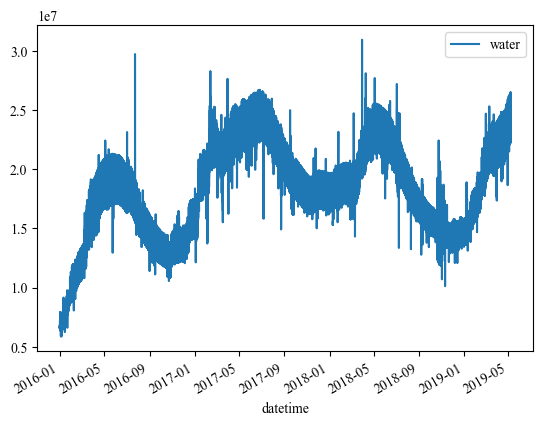

In [199]:
raw_water_level.plot()

#### 降噪算法评估指标

In [200]:
# 本项目主要适用于城市供排水数据处理，通常真实信号的指标未知，因此选择以下两个评估指标
# 最大化corr的同时，保持cov不变
# 具体内容参考：https://kns.cnki.net/kcms2/article/abstract?v=3uoqIhG8C447WN1SO36whLpCgh0R0Z-iszBRSG4W40qHYXhao9i2hhpgdoijgblY-0617ToRRI5yjOYo07aIMM3z-a9nLqDJ&uniplatform=NZKPT
# 相关系数corr
def corr(X, Y):
    return np.corrcoef(Y)

# 协方差Cov
def cov(X, Y):
    return np.cov(X), np.cov(Y)

#### 1.低通滤波(LP)

In [201]:
# 采样频率为一小时，水库水量最高为Max=3.09e+07，要滤除x以上的水量，则 Wn = 2*x/Max
# 相关具体参数请参照：https://blog.csdn.net/chehec2010/article/details/117109246
b, a = sp.signal.butter(8, 0.4, 'lowpass') # 8 表示滤波器的阶数
filtedData = sp.signal.filtfilt(b, a, np.ravel(np.array(raw_water_level)))

CORR: 1.0
COV: (array(1.31918663e+13), array(1.36331316e+13))


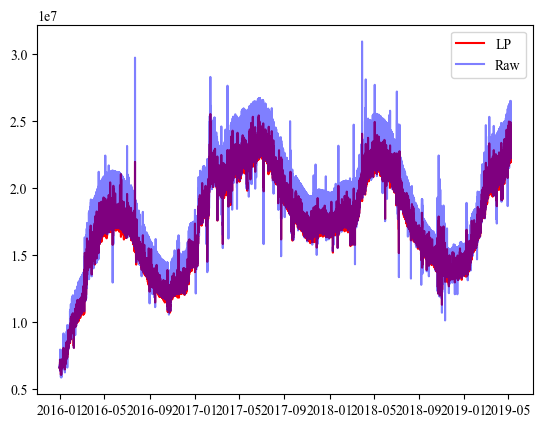

In [202]:
LP_water_level = pd.DataFrame({'water':filtedData}, index=raw_water_level.index)
plt.plot(LP_water_level, label='LP', c='r')
plt.plot(raw_water_level, label='Raw', c='b', alpha=0.5)
plt.legend()
print('CORR:', corr(np.ravel(LP_water_level), np.ravel(raw_water_level)))
print('COV:', cov(np.ravel(LP_water_level), np.ravel(raw_water_level)))

#### 2.移动平均算法(MA)

CORR: 1.0
COV: (array(1.29438094e+13), array(1.36331316e+13))


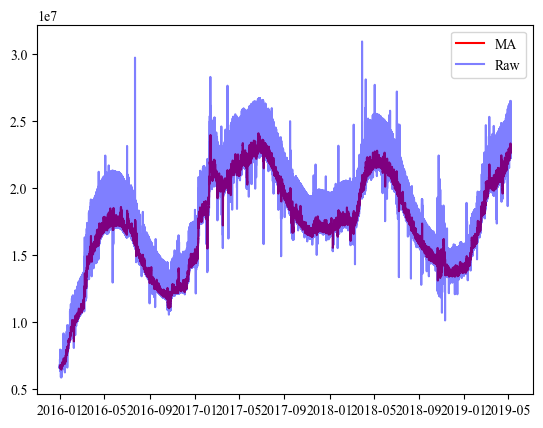

In [219]:
window = 12 #窗口长度
rolling = raw_water_level.rolling(window=window)
MA_water_level = rolling.mean()
plt.plot(MA_water_level, label='MA', c='r')
plt.plot(raw_water_level, label='Raw', c='b', alpha=0.5)
plt.legend()
print('CORR:', corr(np.ravel(MA_water_level), np.ravel(raw_water_level)))
print('COV:', cov(np.ravel(MA_water_level[11:-1]), np.ravel(raw_water_level))) # 当窗口长度为4时，MA_water_level前三个数为NAN，无法计算COV

#### 3.Savitzky-Golay滤波算法(SG)

In [204]:
# window_length：窗口长度，该值需为正奇整数。window_length的值越小，曲线越贴近真实曲线；window_length值越大，平滑效果越厉害。
# k值：polyorder为对窗口内的数据点进行k阶多项式拟合，k的值需要小于window_length。
# k值越大，曲线越贴近真实曲线；k值越小，曲线平滑越厉害。另外，当k值较大时，受窗口长度限制，拟合会出现问题，高频曲线会变成直线。
# mode：确定了要应用滤波器的填充信号的扩展类型。
window_length = 33
k = 10
SG_water_level = sp.signal.savgol_filter(np.ravel(np.array(raw_water_level)), window_length, k, mode='nearest')

CORR: 1.0
COV: (array(1.30839374e+13), array(1.36331316e+13))


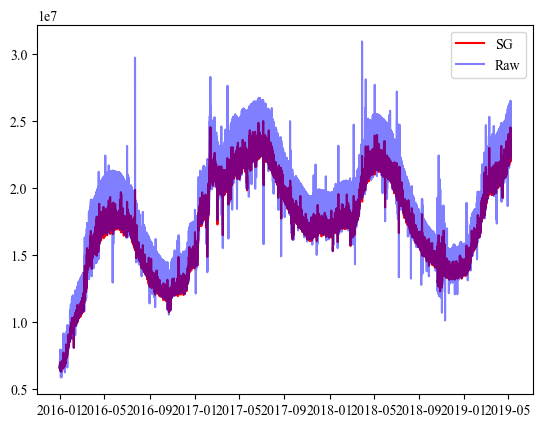

In [205]:
SG_water_level = pd.DataFrame({'water':SG_water_level}, index=raw_water_level.index)
plt.plot(SG_water_level, label='SG', c='r')
plt.plot(raw_water_level, label='Raw', c='b', alpha=0.5)
plt.legend()
print('CORR:', corr(np.ravel(SG_water_level), np.ravel(raw_water_level)))
print('COV:', cov(np.ravel(SG_water_level), np.ravel(raw_water_level)))

#### 4.小波分解滤波算法(DWT)

In [206]:
# 有关pywt以及其他小波函数请参考：https://blog.csdn.net/wsp_1138886114/article/details/116780542
import pywt
wavename = 'db8'
CA, CD = pywt.dwt(np.ravel(np.array(raw_water_level)), wavename) # Approxiamted component (AC); Detailed component (CD)
DWT_AC = np.array((pywt.idwt(CA, None, wavename, 'smooth')))
DWT_CD = np.array(pywt.idwt(None, CD, wavename, 'smooth'))

CORR: 1.0
COV: (array(1.32799973e+13), array(1.36331316e+13))


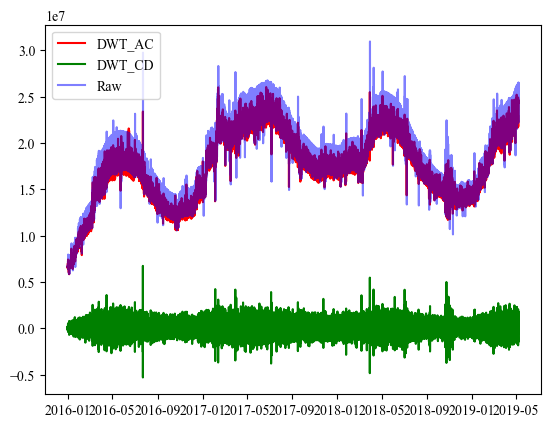

In [212]:
index_new = pd.date_range('2016-01-01', periods=len(DWT_AC), freq='H')
DWT_AC_water_level = pd.DataFrame({'water':DWT_AC}, index=index_new)
DWT_CD_water_level = pd.DataFrame({'water':DWT_CD}, index=index_new)
plt.plot(DWT_AC_water_level, label='DWT_AC', c='r')
plt.plot(DWT_CD_water_level, label='DWT_CD', c='g')
plt.plot(raw_water_level, label='Raw', c='b', alpha=0.5)
plt.legend()
print('CORR:', corr(np.ravel(DWT_AC_water_level), np.ravel(raw_water_level)))
print('COV:', cov(np.ravel(DWT_AC_water_level), np.ravel(raw_water_level)))